In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from hiding_adversarial_attacks.manipulation.utils import get_similarities

import pandas as pd
import seaborn as sns
import torch
import matplotlib.patches as  mpatches
from matplotlib.colors import ListedColormap
from matplotlib import lines
import torch.nn.functional as F
from itertools import cycle

In [2]:
data_path = "/home/steffi/dev/master_thesis/hiding_adversarial_attacks/data/external"
mnist_path = os.path.join(data_path, "MNIST/processed")
fashion_mnist_path = os.path.join(data_path, "FashionMNIST/processed")
cifar10_path = os.path.join(data_path, "CIFAR10")

## DeepFool
adversarial_path = "/home/steffi/dev/master_thesis/hiding_adversarial_attacks/data/preprocessed/adversarial"
fashion_mnist_adv_path = os.path.join(adversarial_path, "data-set=FashionMNIST--attack=DeepFool--eps=0.105--cp-run=HAA-1728")
cifar10_adv_path = os.path.join(adversarial_path, "data-set=CIFAR10--attack=DeepFool--eps=0.1--cp-run=HAA-943")

# DeepLIFT
fashion_mnist_path_gradcam = os.path.join(fashion_mnist_adv_path, "exp=DeepLIFT--bl=zero--mbi=False")
cifar10_path_gradcam = os.path.join(cifar10_adv_path, "exp=DeepLIFT--bl=local_mean--mbi=False")


## Load data

In [3]:
def load_explanations(data_set_path: str):
    train_expl_orig, train_labels_orig, _ = torch.load(os.path.join(data_set_path, "training_orig_exp.pt"))
    train_expl_adv, train_labels_adv, _ = torch.load(os.path.join(data_set_path, "training_adv_exp.pt"))
    return train_expl_orig, train_labels_orig, train_expl_adv, train_labels_adv

### Mapping FashionMNIST and CIFAR10

In [6]:
fashion_mnist_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

cifar10_mapping = {
    0: "Airplane",
    1: "Car",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck",
}

# DeepLIFT

In [7]:
# Explanations
fashion_mnist_train_expl_orig, fashion_mnist_train_label_orig, fashion_mnist_train_expl_adv, fashion_mnist_train_label_adv = load_explanations(fashion_mnist_path_gradcam)
cifar10_train_expl_orig, cifar10_train_label_orig, cifar10_train_expl_adv, cifar10_train_label_adv = load_explanations(cifar10_path_gradcam)

In [8]:
fashion_mnist_train_expl_orig = F.relu(fashion_mnist_train_expl_orig)
fashion_mnist_train_expl_adv = F.relu(fashion_mnist_train_expl_adv)

cifar10_train_expl_orig = F.relu(cifar10_train_expl_orig)
cifar10_train_expl_adv = F.relu(cifar10_train_expl_adv)

In [9]:
reverse_mse, fashion_mnist_similarities_mse = get_similarities("MSE", fashion_mnist_train_expl_orig, fashion_mnist_train_expl_adv)
reverse_pcc, fashion_mnist_similarities_pcc = get_similarities("PCC", fashion_mnist_train_expl_orig, fashion_mnist_train_expl_adv)

reverse_mse, cifar10_similarities_mse = get_similarities("MSE", cifar10_train_expl_orig, cifar10_train_expl_adv)
reverse_pcc, cifar10_similarities_pcc = get_similarities("PCC", cifar10_train_expl_orig, cifar10_train_expl_adv)

/home/steffi/dev/master_thesis/hiding_adversarial_attacks/src/hiding_adversarial_attacks/manipulation/utils.py:232: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  batched_sim_loss = vmap(similarity_loss)


In [10]:
fashion_mnist_sim = pd.DataFrame([fashion_mnist_similarities_mse.numpy(), fashion_mnist_similarities_pcc.numpy(), fashion_mnist_train_label_orig.numpy(), fashion_mnist_train_label_adv.numpy()], index=["mse_sim", "pcc_sim", "orig_label", "adv_label"]).T
fashion_mnist_sim["orig_label_name"] = fashion_mnist_sim["orig_label"].map(fashion_mnist_mapping)

In [11]:
cifar10_sim = pd.DataFrame([cifar10_similarities_mse.numpy(), cifar10_similarities_pcc.numpy(), cifar10_train_label_orig.numpy(), cifar10_train_label_adv.numpy()], index=["mse_sim", "pcc_sim", "orig_label", "adv_label"]).T
cifar10_sim["orig_label_name"] = cifar10_sim["orig_label"].map(cifar10_mapping)

In [12]:
color_palette = sns.color_palette("BuPu")

In [13]:
fashion_mnist_sim.head()

,mse_sim,pcc_sim,orig_label,adv_label,orig_label_name
0,0.036056,0.062671,7.0,8.0,Sneaker
1,0.585741,-0.016652,1.0,0.0,Trouser
2,0.151116,0.184213,7.0,9.0,Sneaker
3,0.181906,0.170610,4.0,2.0,Coat
4,0.319244,0.030196,1.0,3.0,Trouser


# Heatmaps for mean similarities

In [14]:
def plot_similarity_heatmap(similarities, sim_type, title: str = None, yticklabels = None, xticklabels=None, cmap=sns.diverging_palette(220, 20, as_cmap=True)):
    df = similarities[[sim_type, "orig_label", "adv_label"]].groupby(["orig_label", "adv_label"]).mean().reset_index().pivot(columns='adv_label',index='orig_label',values=sim_type).fillna(0)
    fig = plt.figure(figsize=(12, 8))
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = True, labeltop=True)
    
    limits = [-1, 1]
    fmt = ".2f"
    cmap = sns.diverging_palette(h_neg=240, h_pos=10, s=100, l=30,  n=20, as_cmap=True)
    if sim_type == "mse_sim":
        limits = [0, None]
        cmap = sns.color_palette("Reds_r", as_cmap=True)
        fmt = ".3g"
        
    ax = sns.heatmap(df, annot=True, fmt=fmt, cmap=cmap, vmin=limits[0], vmax=limits[1])
    ax.xaxis.set_label_position('top') 
    if yticklabels is not None:
        ax.set_yticklabels(yticklabels)
        ax.yaxis.set_tick_params(rotation=0)
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels)
    if title is not None:
        plt.title(title)

## FashionMNIST

## MSE

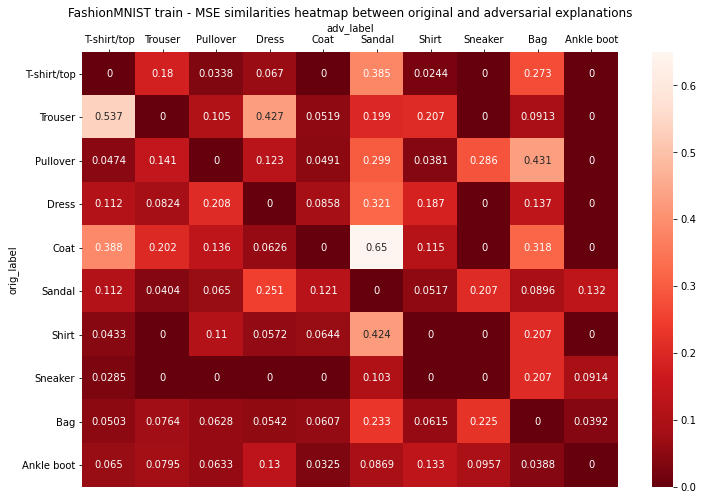

In [15]:
plot_similarity_heatmap(fashion_mnist_sim, "mse_sim", xticklabels=list(fashion_mnist_mapping.values()), yticklabels=list(fashion_mnist_mapping.values()), title="FashionMNIST train - MSE similarities heatmap between original and adversarial explanations")

## PCC

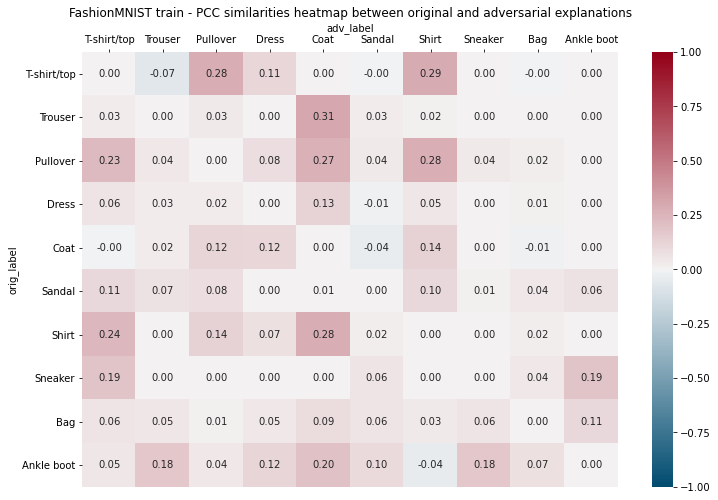

In [16]:
plot_similarity_heatmap(fashion_mnist_sim, "pcc_sim", xticklabels=list(fashion_mnist_mapping.values()), yticklabels=list(fashion_mnist_mapping.values()), title="FashionMNIST train - PCC similarities heatmap between original and adversarial explanations")

## CIFAR10

## MSE

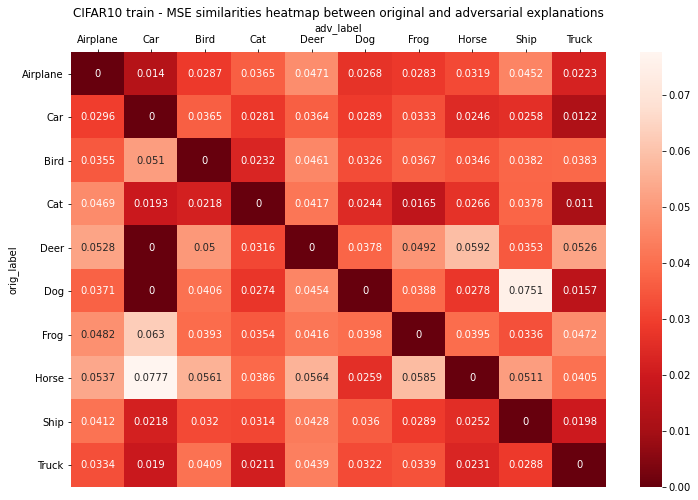

In [17]:
plot_similarity_heatmap(cifar10_sim, "mse_sim", xticklabels=list(cifar10_mapping.values()), yticklabels=list(cifar10_mapping.values()), title="CIFAR10 train - MSE similarities heatmap between original and adversarial explanations")

## PCC

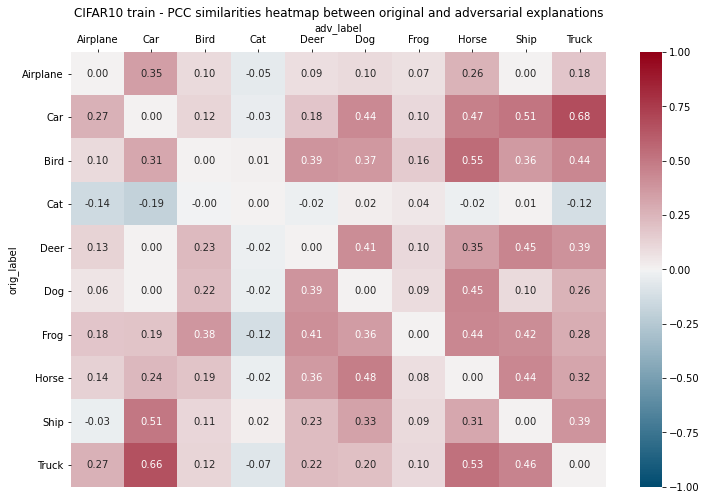

In [18]:
plot_similarity_heatmap(cifar10_sim, "pcc_sim", xticklabels=list(cifar10_mapping.values()), yticklabels=list(cifar10_mapping.values()), title="CIFAR10 train - PCC similarities heatmap between original and adversarial explanations")

# Distribution plots for each data set's explanation similarities by metric

### Plotting function

In [19]:
def plot_similarities_histograms(group, x, title, means, log=True, color="purple"):
    fig, axes = plt.subplots(2,5, figsize=(15,8), sharex=True, sharey=True)
    for (label, g), ax, mean in zip(group, axes.flatten(), means):
        g.plot(kind='hist', x=x, ax=ax, title=label, color=color, log=log)
        ax.axvline(mean, color='red', linestyle='dashed', linewidth=2)
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()

In [20]:
def plot_similarities_kde_with_boxplot(group, x, title, means, log_x=False, log_y=False, ylim_factor=1.06):
    fig, axes = plt.subplots(5,2, figsize=(16,12), sharex=True, sharey=True)
    color_p = ["Wistia", "PuRd"]
    if x == "mse_sim":
        color_p = ["PuRd", "Wistia"]
    color_palette = sns.color_palette(color_p[0], 5)
    p = sns.color_palette(color_p[1], 1)
                         
    idx = 0
    for (label, g), ax, mean in zip(group, axes.flatten(), means):
        if log_x:
            ax.set_xscale('log')
        if log_y:
            ax.set_yscale('log')
        ax.set_title(label)
        ax2 = ax.twinx()
            
        ax = sns.histplot(g, ax=ax, palette=p, label=x)
        y_lim = int(ax.get_ylim()[1] * ylim_factor)
        ax.set(ylim=(-5, y_lim))
        sns.boxplot(data=g, x=x, ax=ax2, color=color_palette[2])
        ax2.set(ylim=(-5, 1))
        mean_l = ax2.axvline(mean, color=color_palette[3], linestyle='dashed', linewidth=5, label="mean")
        ax.legend(loc='lower left')
        
        
    #fig.legend(handles=[ax], labels=range(0, 11))
    #plt.legend(handles=[ mean_l])   
    fig.suptitle(title, fontsize=16)
   
    plt.tight_layout()

## FashionMNIST

### MSE

In [21]:
fashion_mnist_sim.sort_values(by="orig_label")[["mse_sim", "orig_label_name"]].groupby("orig_label_name", sort=False)

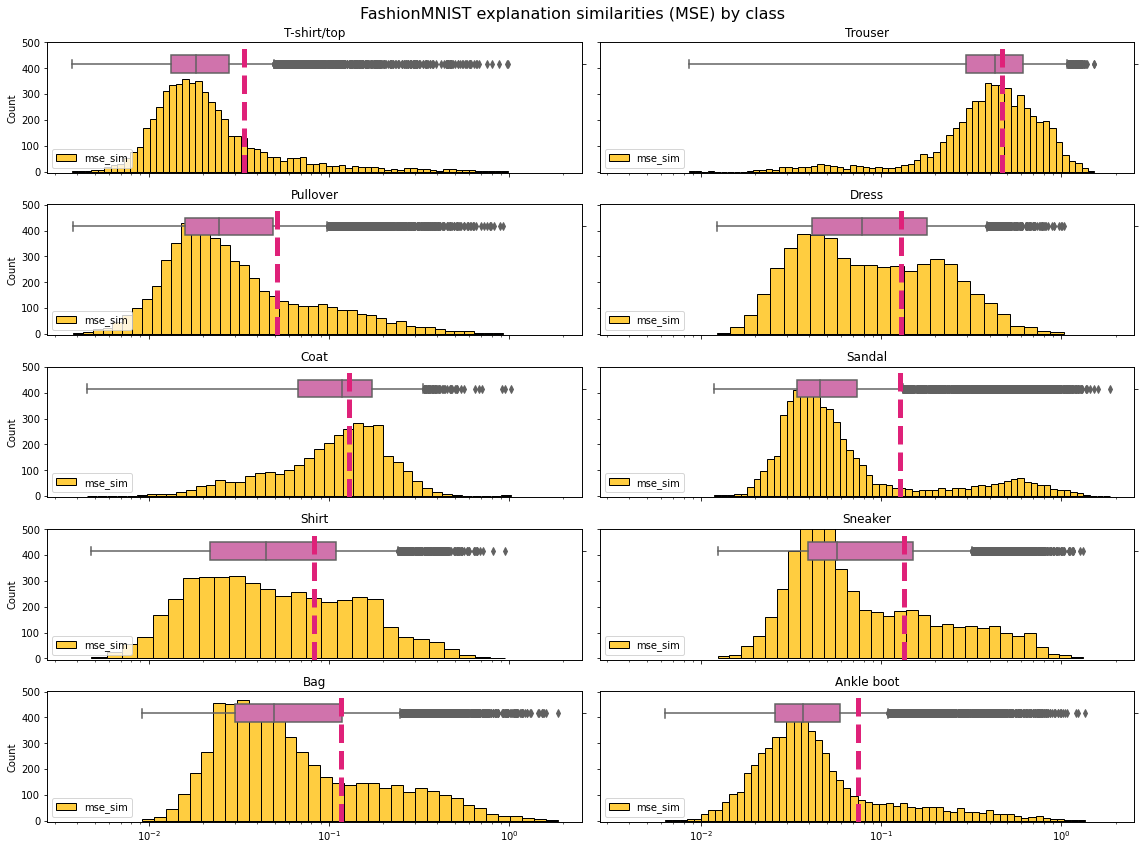

In [22]:
group = fashion_mnist_sim.sort_values(by="orig_label")[["mse_sim", "orig_label_name"]].groupby("orig_label_name", sort=False)
means = group.mean().values.flatten()

plot_similarities_kde_with_boxplot(group, "mse_sim", "FashionMNIST explanation similarities (MSE) by class", means, log_x=True, ylim_factor=1.03)

### Findings FashionMNIST MSE (lower is better)
* 

### PCC

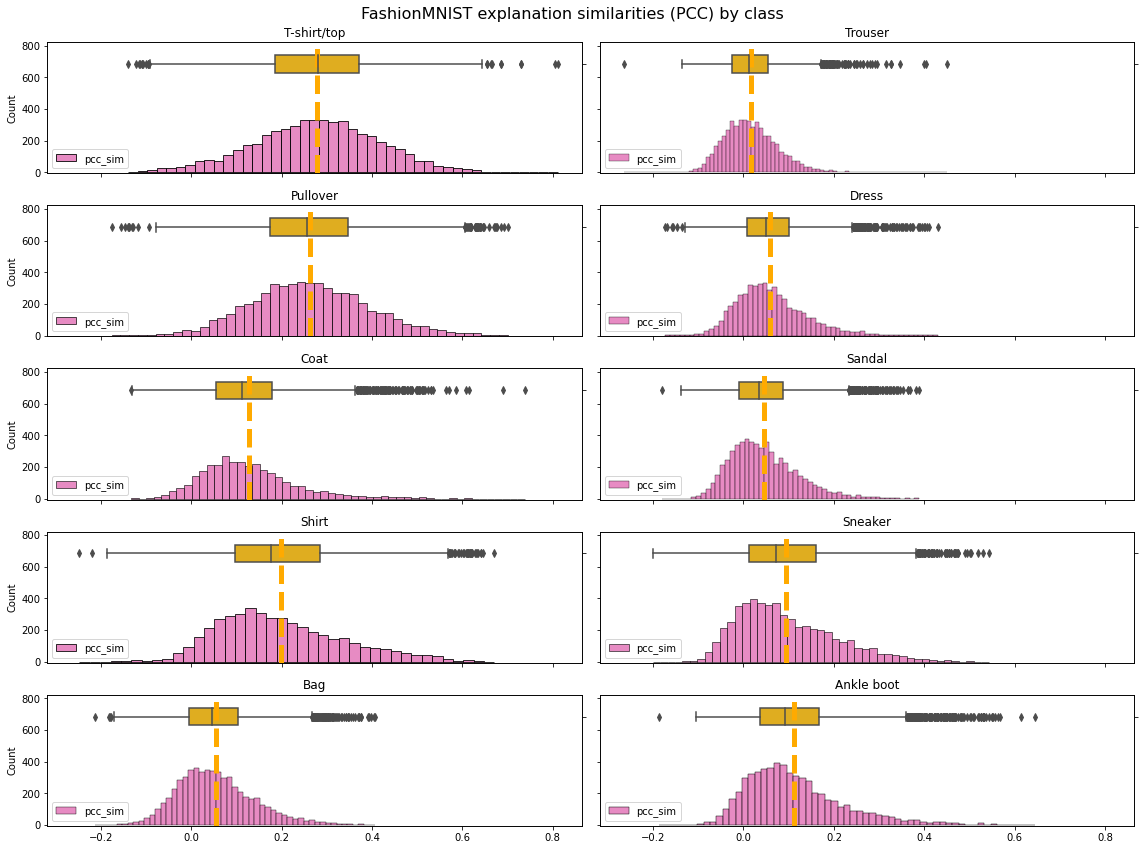

In [23]:
group = fashion_mnist_sim.sort_values(by="orig_label")[["pcc_sim", "orig_label_name"]].groupby("orig_label_name", sort=False)
means = group.mean().values.flatten()

plot_similarities_kde_with_boxplot(group, "pcc_sim", "FashionMNIST explanation similarities (PCC) by class", means, log_x=False, ylim_factor=1.09)

### Findings FashionMNIST PCC (higher is better)
* 

## CIFAR10

### MSE

In [26]:
cifar10_sim.sort_values(by="orig_label")["orig_label_name"].unique()

array(['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse',
       'Ship', 'Truck'], dtype=object)

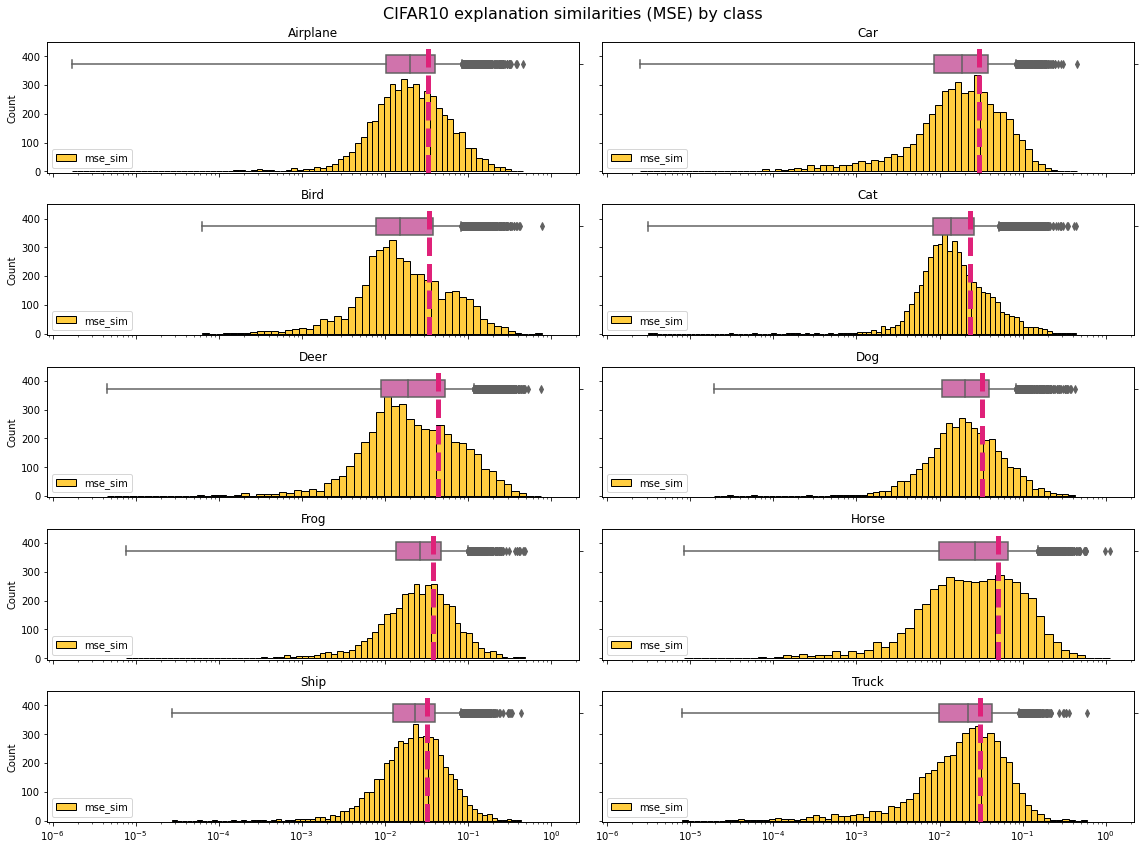

In [27]:
group = cifar10_sim.sort_values(by="orig_label")[["mse_sim", "orig_label_name"]].groupby("orig_label_name", sort=False)
means = group.mean().values.flatten()

plot_similarities_kde_with_boxplot(group, "mse_sim", "CIFAR10 explanation similarities (MSE) by class", means, log_x=True, ylim_factor=1.03)

### Findings CIFAR10 MSE (lower is better)


### PCC

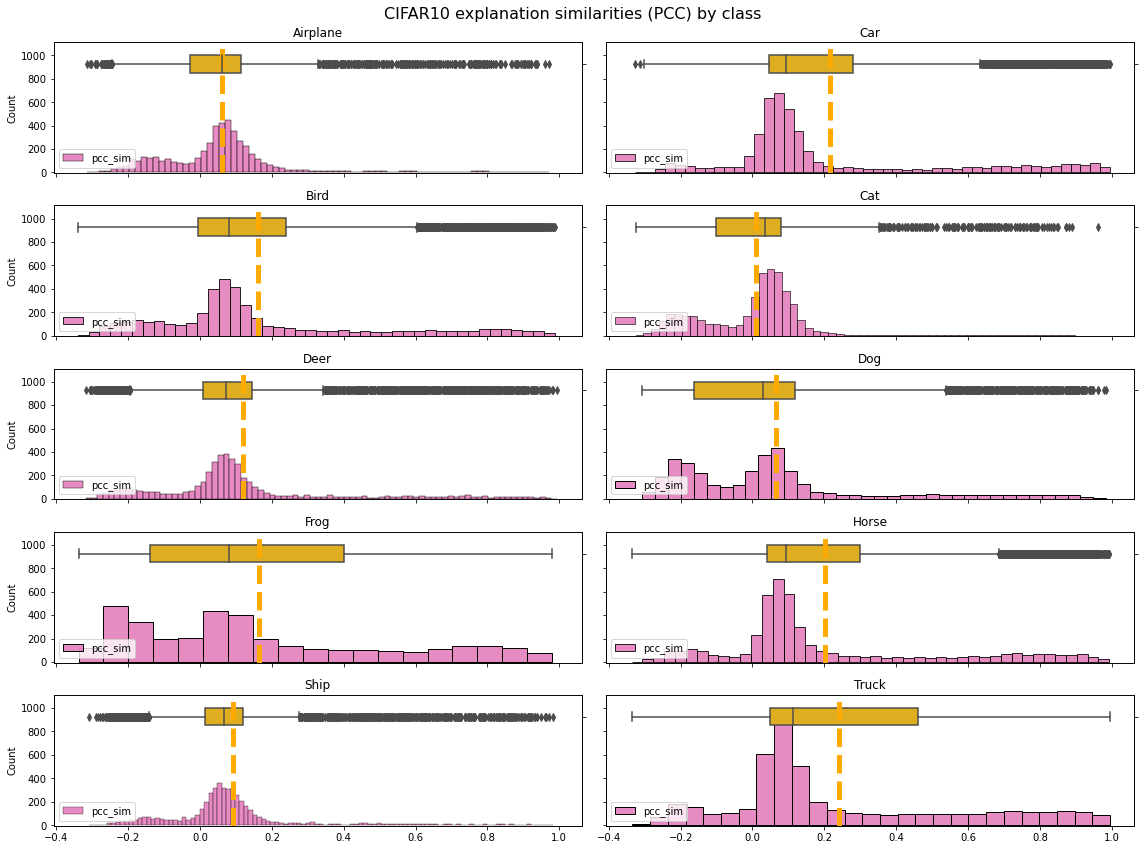

In [28]:
group = cifar10_sim.sort_values(by="orig_label")[["pcc_sim", "orig_label_name"]].groupby("orig_label_name", sort=False)
means = group.mean().values.flatten()

plot_similarities_kde_with_boxplot(group, "pcc_sim", "CIFAR10 explanation similarities (PCC) by class", means, log_x=False, ylim_factor=1.09)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = True, bottom=False, top = False, labeltop=False)


### Findings CIFAR10 PCC (higher is better)
* Car (1), Truck (9) and  Horse (7) look most promising with means > 0 
* Unpromising: Dog (5), Cat (3), Airplane (0)

# Distribution plots (KDE) for all data sets per metric & adversarial class

In [29]:
palette=sns.color_palette("tab20", 10)

In [30]:
def get_handles_from_labels(labels, palette=sns.color_palette("tab20", 10)):   
    return [lines.Line2D([0], [0], ls='-', c=c) for l, c in zip(labels, palette)]

## FashionMNIST

### MSE KDE plot

/home/steffi/.conda/envs/hiding_adversarial_attacks/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/steffi/.conda/envs/hiding_adversarial_attacks/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/steffi/.conda/envs/hiding_adversarial_attacks/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/steffi/.conda/envs/hiding_adversarial_attacks/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/steffi/.conda/envs/hiding_adversarial_attacks/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density esti

Text(0.5, 0.98, 'FashionMNIST KDE plots per original label for MSE explanation similarity of adversarial class')

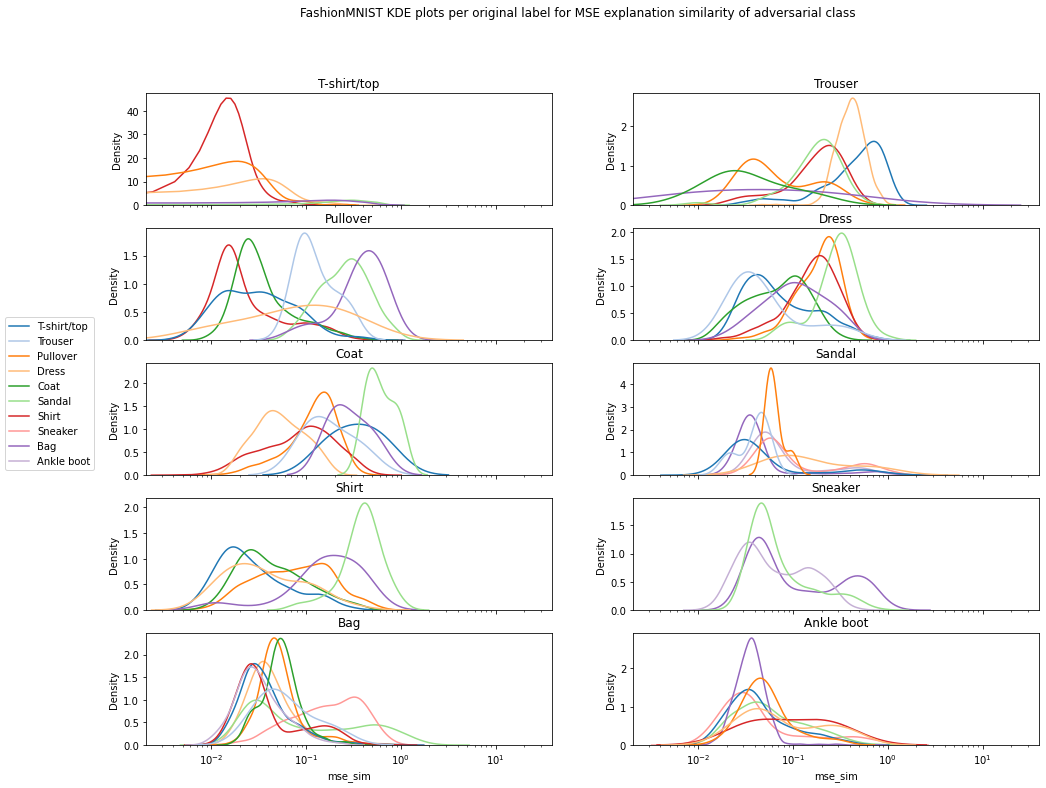

In [31]:
categories = list(fashion_mnist_sim.sort_values(by="orig_label")["orig_label_name"].unique())
fig, axes = plt.subplots(5,2, figsize=(16,12), sharex=True)
for idx, (cat, ax) in enumerate(zip(categories, axes.flatten())):
    class_sim = fashion_mnist_sim[fashion_mnist_sim["orig_label_name" ] == cat]
    
    adv_categories = list(class_sim["adv_label"].unique())
    _palette = [palette[int(c)] for c in adv_categories]
    
    for adv_cat, color in zip(adv_categories, _palette):
        sim = class_sim[class_sim["adv_label" ] == adv_cat]
        ax = sns.kdeplot(data=sim, x="mse_sim", ax=ax, color=color, label=fashion_mnist_mapping[int(adv_cat)])
        #ax.legend()
    ax.set_xscale('log')
    ax.set_title(cat)

labels = list(fashion_mnist_mapping.values())
handles = get_handles_from_labels(labels)
    
fig.legend(handles, labels, loc='center left')
fig.suptitle("FashionMNIST KDE plots per original label for MSE explanation similarity of adversarial class")

### PCC KDE plot

/home/steffi/.conda/envs/hiding_adversarial_attacks/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/steffi/.conda/envs/hiding_adversarial_attacks/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/steffi/.conda/envs/hiding_adversarial_attacks/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/steffi/.conda/envs/hiding_adversarial_attacks/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/steffi/.conda/envs/hiding_adversarial_attacks/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density esti

Text(0.5, 0.98, 'FashionMNIST KDE plots per original label for PCC explanation similarity of adversarial class')

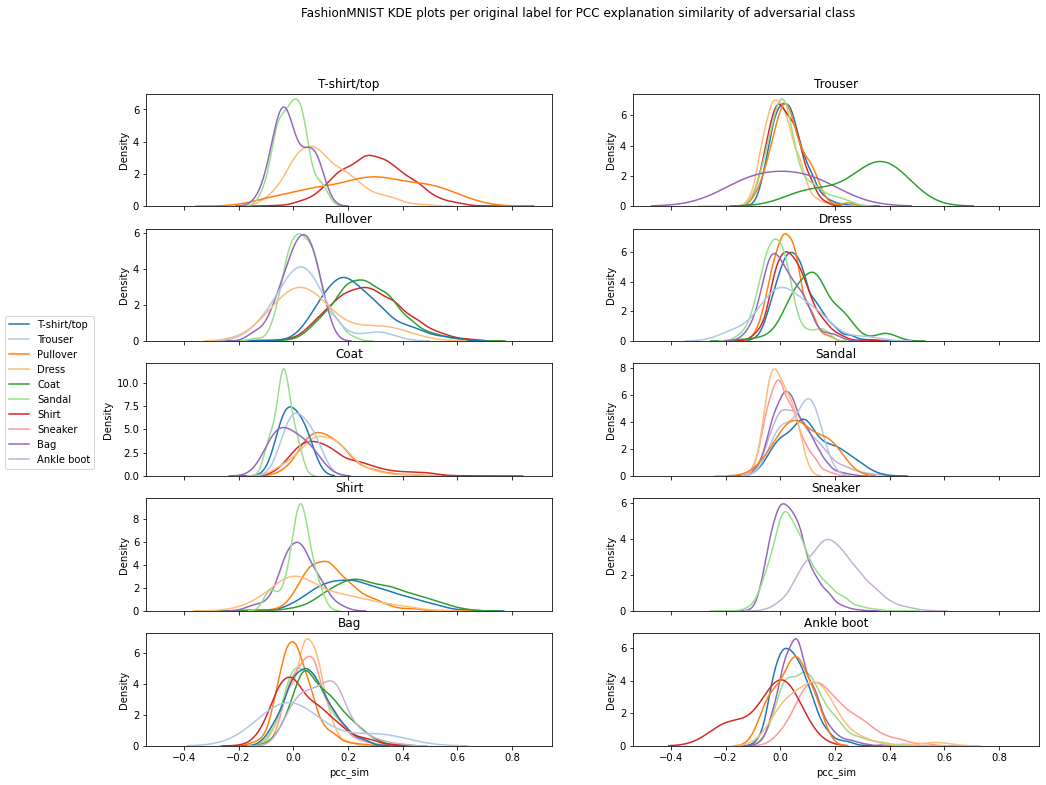

In [32]:
categories = list(fashion_mnist_sim.sort_values(by="orig_label")["orig_label_name"].unique())
fig, axes = plt.subplots(5,2, figsize=(16,12), sharex=True)
for idx, (cat, ax) in enumerate(zip(categories, axes.flatten())):
    class_sim = fashion_mnist_sim[fashion_mnist_sim["orig_label_name" ] == cat]
    
    adv_categories = list(class_sim["adv_label"].unique())
    _palette = [palette[int(c)] for c in adv_categories]
    
    for adv_cat, color in zip(adv_categories, _palette):
        sim = class_sim[class_sim["adv_label" ] == adv_cat]
        ax = sns.kdeplot(data=sim, x="pcc_sim", ax=ax, color=color, label=fashion_mnist_mapping[int(adv_cat)])
        #ax.legend()
    #ax.set_xscale('log')
    ax.set_title(cat)
    
labels = list(fashion_mnist_mapping.values())
handles = get_handles_from_labels(labels)
    
fig.legend(handles, labels, loc='center left')
fig.suptitle("FashionMNIST KDE plots per original label for PCC explanation similarity of adversarial class")

## CIFAR10

## KDE plot MSE

Text(0.5, 0.98, 'CIFAR10 KDE plots per original label for MSE explanation similarity of adversarial class')

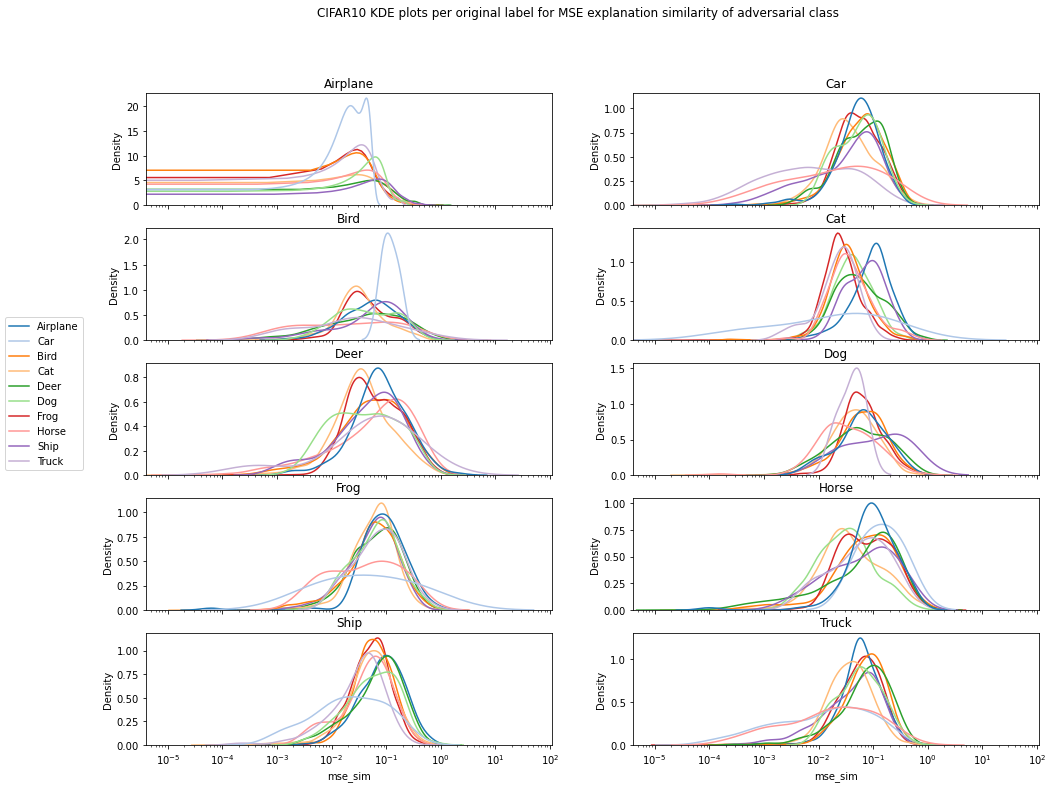

In [31]:
categories = list(cifar10_sim.sort_values(by="orig_label")["orig_label_name"].unique())
fig, axes = plt.subplots(5,2, figsize=(16,12), sharex=True)
for idx, (cat, ax) in enumerate(zip(categories, axes.flatten())):
    class_sim = cifar10_sim[cifar10_sim["orig_label_name" ] == cat]
    
    adv_categories = list(class_sim["adv_label"].unique())
    _palette = [palette[int(c)] for c in adv_categories]
    
    for adv_cat, color in zip(adv_categories, _palette):
        sim = class_sim[class_sim["adv_label" ] == adv_cat]
        ax = sns.kdeplot(data=sim, x="mse_sim", ax=ax, color=color, label=cifar10_mapping[int(adv_cat)])
        #ax.legend()
    ax.set_xscale('log')
    ax.set_title(cat)

    
labels = list(cifar10_mapping.values())
handles = get_handles_from_labels(labels)
    
fig.legend(handles, labels, loc='center left')
fig.suptitle("CIFAR10 KDE plots per original label for MSE explanation similarity of adversarial class")

## KDE Plot PCC

Text(0.5, 0.98, 'CIFAR10 KDE plots per original label for PCC explanation similarity of adversarial class')

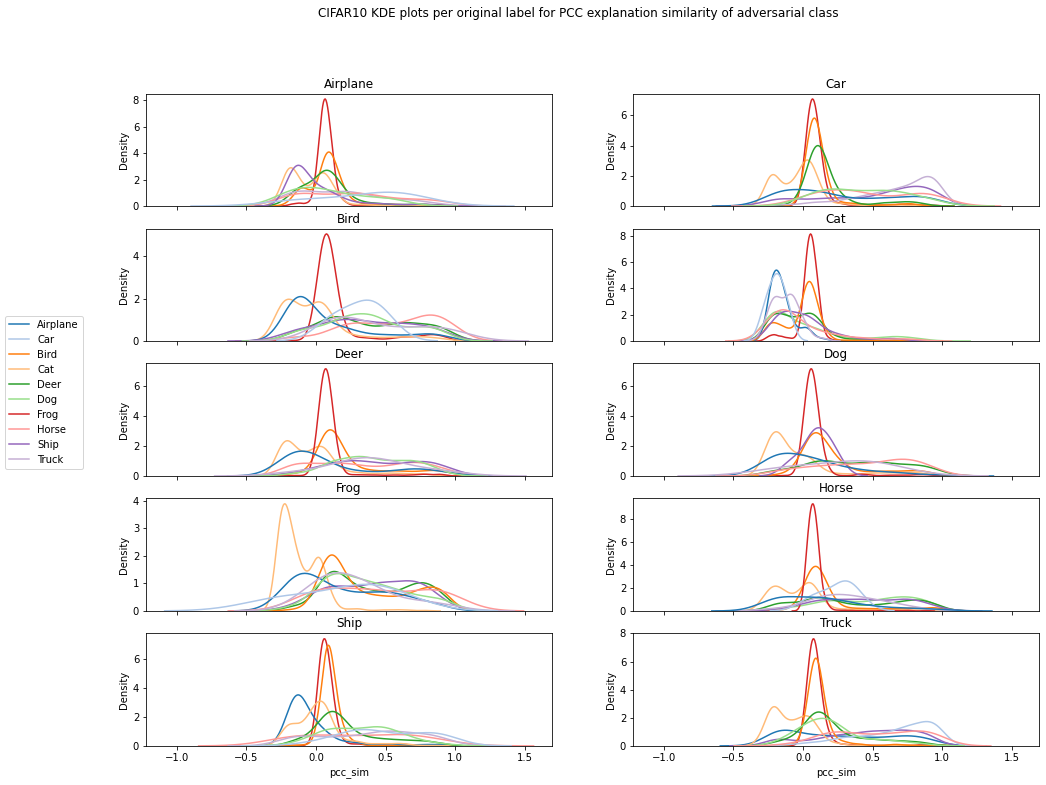

In [33]:
categories = list(cifar10_sim.sort_values(by="orig_label")["orig_label_name"].unique())
fig, axes = plt.subplots(5,2, figsize=(16,12), sharex=True)
for idx, (cat, ax) in enumerate(zip(categories, axes.flatten())):
    class_sim = cifar10_sim[cifar10_sim["orig_label_name" ] == cat]
    
    adv_categories = list(class_sim["adv_label"].unique())
    _palette = [palette[int(c)] for c in adv_categories]
    
    for adv_cat, color in zip(adv_categories, _palette):
        sim = class_sim[class_sim["adv_label" ] == adv_cat]
        ax = sns.kdeplot(data=sim, x="pcc_sim", ax=ax, color=color, label=cifar10_mapping[int(adv_cat)])
        #ax.legend()
    #ax.set_xscale('log')
    ax.set_title(cat)

labels = list(cifar10_mapping.values())
handles = get_handles_from_labels(labels)
    
fig.legend(handles, labels, loc='center left')
fig.suptitle("CIFAR10 KDE plots per original label for PCC explanation similarity of adversarial class")